In [1]:
import os
import time

from jax import numpy as np

import numpy as npnp
import numpy.random as npr

import matplotlib
import matplotlib.animation 
import matplotlib.pyplot as plt
matplotlib.rcParams["animation.embed_limit"] = 1024

plt.rcParams['figure.dpi'] = 300
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.size"] = 10

import skimage
import skimage.io as sio
import skimage.transform
import fracatal

from fracatal.functional_jax import ft_convolve, \
        make_gaussian, \
        make_mixed_gaussian, \
        make_kernel_field, \
        make_update_function, \
        make_update_step, \
        make_make_kernel_function, \
        sigmoid_1, \
        get_smooth_steps_fn, \
        make_make_smoothlife_kernel_function, \
        make_smooth_interval, \
        compute_entropy, \
        compute_frequency_ratio, \
        compute_frequency_entropy, \
        make_smoothlife_update_function, \
        make_smoothlife_update_step
        
from fracatal.scripts import v_stability_sweep, stability_sweep     

import IPython

In [2]:
"""
animation functions
"""

def get_fig(grid):
    
    global subplot_0
    
    fig, ax = plt.subplots(1,1)
    
    subplot_0 = ax.imshow(grid.squeeze(), cmap="magma")
    
    return fig, ax

def update_frame(ii):
    
    global grid
    
    subplot_0.set_array(grid.squeeze())
    
    grid = update_step(grid)

def make_inverted_cmap(cmap_name: str="magma") -> callable:

    my_cmap = plt.get_cmap(cmap_name)

    def inverted_cmap(x):

        result = 1.0 - np.array(my_cmap(x))[...,:3]

        return result
        

    return inverted_cmap

def calculate_center_of_mass(grid, spacing=20):
    # adapted from rivesunder/yuca
    # simplified, no accounting for edge crossing
    
    if len(grid.shape) > 2:
        my_grid = np.array(grid.squeeze())
    else:
        my_grid = np.array(1.0 * grid)
     
    xx_grid, yy_grid = np.meshgrid(np.arange(my_grid.shape[-1]), np.arange(my_grid.shape[-2]))

    # pattern is not at an edge crossing
    
    com_x = (xx_grid * my_grid) / my_grid.sum()
    com_y = (yy_grid * my_grid) / my_grid.sum()

    return com_x.sum(), com_y.sum()

my_cmap = make_inverted_cmap()
my_cmap_gray = make_inverted_cmap("gray")

In [3]:
root_dir = ".." 
pattern_filename = os.path.join(root_dir, "patterns", "asymdrop.npy")

pattern = np.load(pattern_filename)

kernel_amplitudes = [1.0]
kernel_means = [0.5]
kernel_sds = [0.15]
k0 = 13
kernel_dim = k0*2

make_kernel = make_make_kernel_function(kernel_amplitudes, kernel_means, kernel_sds, dim=kernel_dim)
kernel = make_kernel(k0)

target_mean = 0.12
target_sd = 0.005
target_function = make_update_function(target_mean, target_sd, mode=1)

horizontal_pattern = skimage.transform.rotate(npnp.array(pattern).squeeze(), -75, resize=True)

max_steps = 100
trajectories = []
for dt in [0.17, .26, 0.2]:
    
    update_step = make_update_step(target_function, kernel, dt, mode=1, clipping_function=lambda x: x)
    
    grid_height = 64
    grid_width = grid_height * 3
    
    corner_x = (grid_height - pattern.shape[-2]) // 2
    grid = np.zeros((1,1, 64, 192))
    grid = grid.at[:,:,corner_x:corner_x+horizontal_pattern.shape[-2], :horizontal_pattern.shape[-1]].set(horizontal_pattern)
    
    trajectory = []
    grid_0 = 1.0 * grid
    for step in range(max_steps):
        trajectory.append(calculate_center_of_mass(grid))
        grid = update_step(grid)

    
    import copy
    trajectories.append(copy.deepcopy(trajectory))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


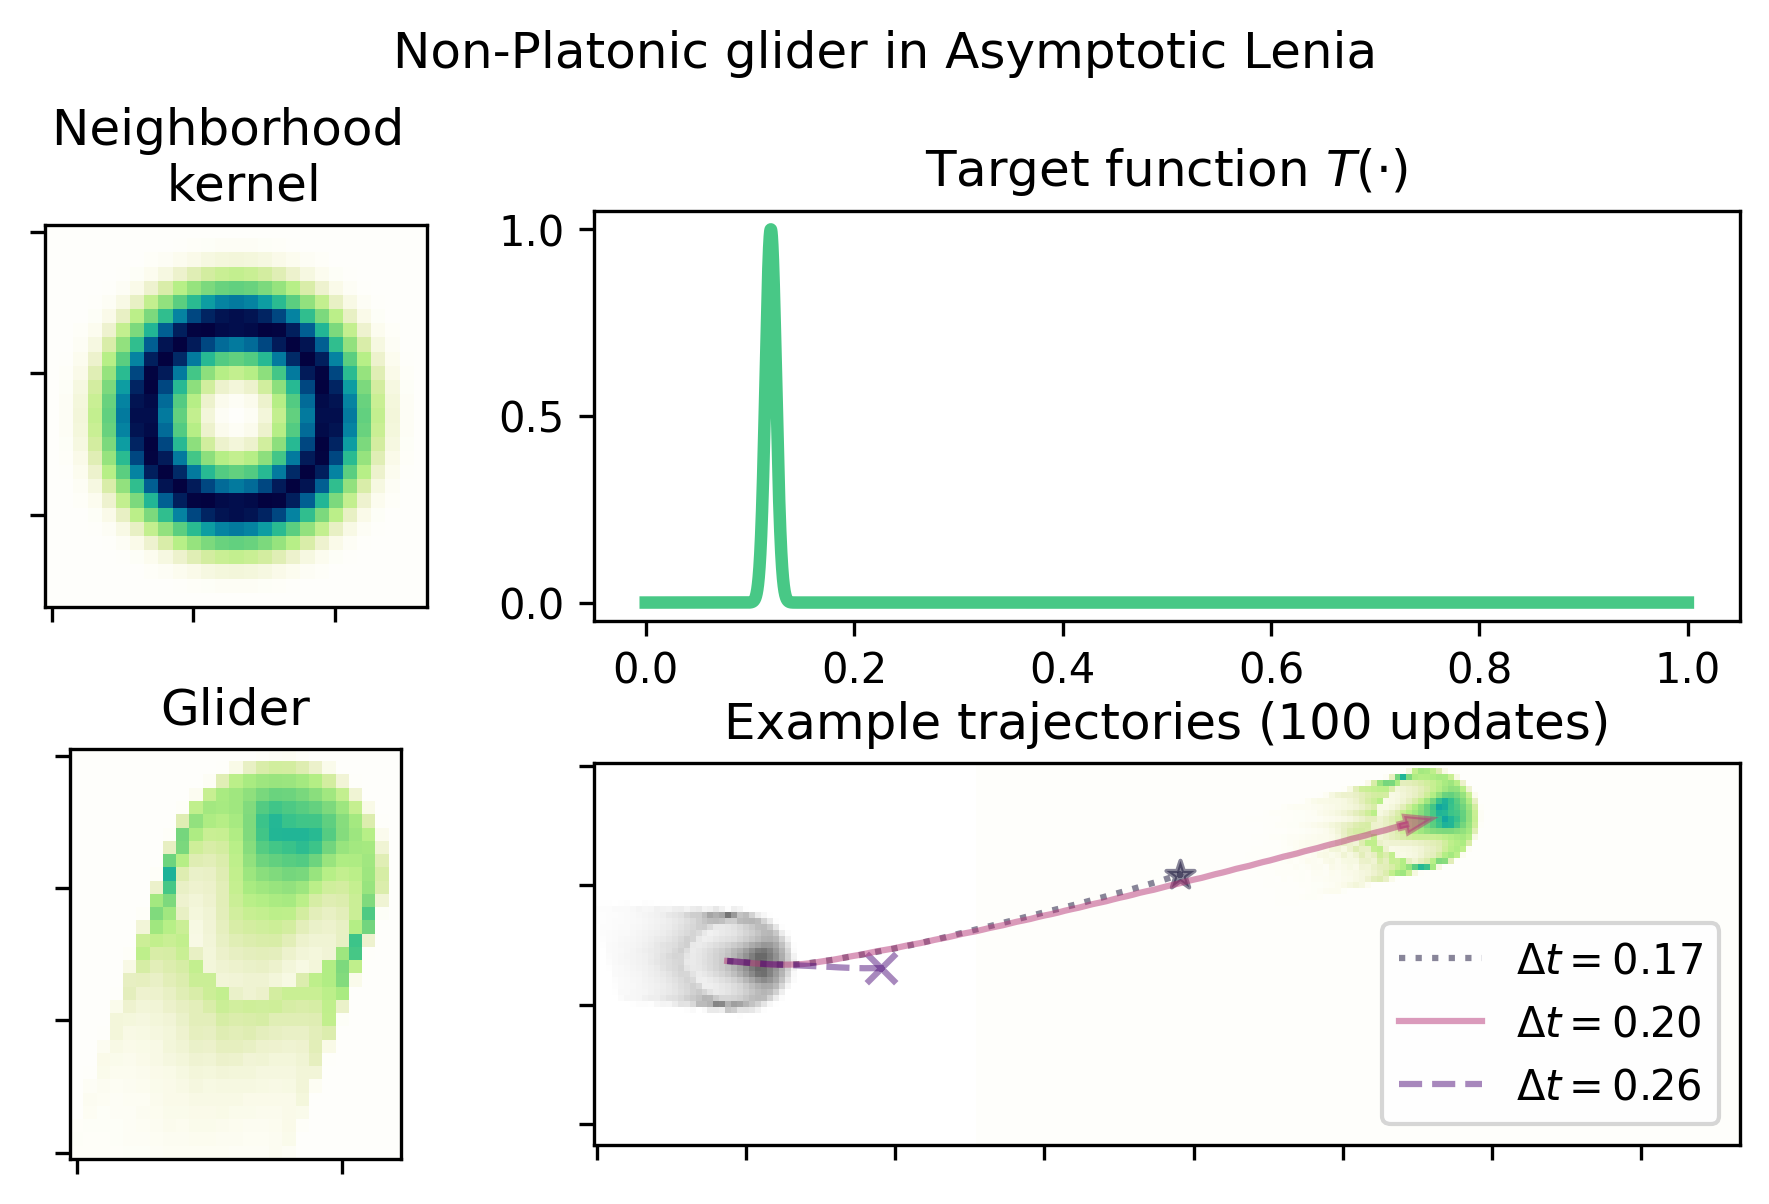

In [4]:

x = np.arange(0, 1.0, 0.00001)
fig, ax = plt.subplots(2,2, figsize=(6,4), width_ratios=[0.25, 0.75], height_ratios=[1.,1.])

line_color_0 = [elem.item() for elem in my_cmap(0.5)]
line_color_1 = [elem.item() for elem in plt.get_cmap("magma")(0.5)]
line_color_2 = [elem.item() for elem in plt.get_cmap("magma")(0.1)]
line_color_3 = [elem.item() for elem in plt.get_cmap("magma")(0.25)]
                
ax[0,0].imshow(my_cmap(kernel.squeeze()/kernel.max()), cmap="magma")
ax[1,0].imshow(my_cmap(pattern.squeeze()), cmap="magma")

ax[0, 1].plot(x, target_function(x), lw=3, color=line_color_0)

display_grid = np.zeros((*grid.shape, 3))
display_grid = display_grid.at[:,:,:,:64].set(my_cmap_gray(grid_0[:,:,:,:64].squeeze()))
display_grid = display_grid.at[:,:,:,64:].set(my_cmap(grid[:,:,:,64:].squeeze()))

ax[1,1].imshow(display_grid.squeeze())

trajectory_17 = trajectories[0]
trajectory_20 = trajectories[2]
trajectory_26 = trajectories[1]

ax[1,1].plot([elem[0] for elem in trajectory_17], [elem[1] for elem in trajectory_17],":",  alpha=0.5, \
             color=line_color_2, label="$\Delta t = 0.17$")
ax[1,1].plot([elem[0] for elem in trajectory_20], [elem[1] for elem in trajectory_20], alpha=0.5, \
             color=line_color_1, label="$\Delta t = 0.20$")
ax[1,1].plot([elem[0] for elem in trajectory_26], [elem[1] for elem in trajectory_26], "--", alpha=0.5, \
             color=line_color_3, label="$\Delta t = 0.26$")

ax[1,1].scatter(trajectory_17[-1][0].item(), trajectory_17[-1][1].item(), s=50, marker="*", alpha=0.5, color=line_color_2)
ax[1,1].scatter(trajectory_26[-1][0].item(), trajectory_26[-1][1].item(), s=50, marker="x", alpha=0.5, color=line_color_3)

plt.arrow(trajectory[-2][0], trajectory[-2][1], \
         trajectory[-1][0] - trajectory[-2][0], \
         trajectory[-1][1] - trajectory[-2][1],\
         width=1, color=line_color_1, alpha=0.5)

ax[0,0].set_title("Neighborhood \n kernel")
ax[0,1].set_title("Target function $T(\cdot)$")
ax[1,0].set_title("Glider")
ax[1,1].set_title("Example trajectories (100 updates)")
ax[1,1].legend(loc=4)

for ii in range(2):
    for jj in range(2):
        if ii == 0 and jj == 1:
            pass
        else:
            ax[ii,jj].set_yticklabels("")
            ax[ii,jj].set_xticklabels("")
            
fig.suptitle("Non-Platonic glider in Asymptotic Lenia")
plt.tight_layout()
plt.savefig(f"asymdrop_summary.png")
plt.show()

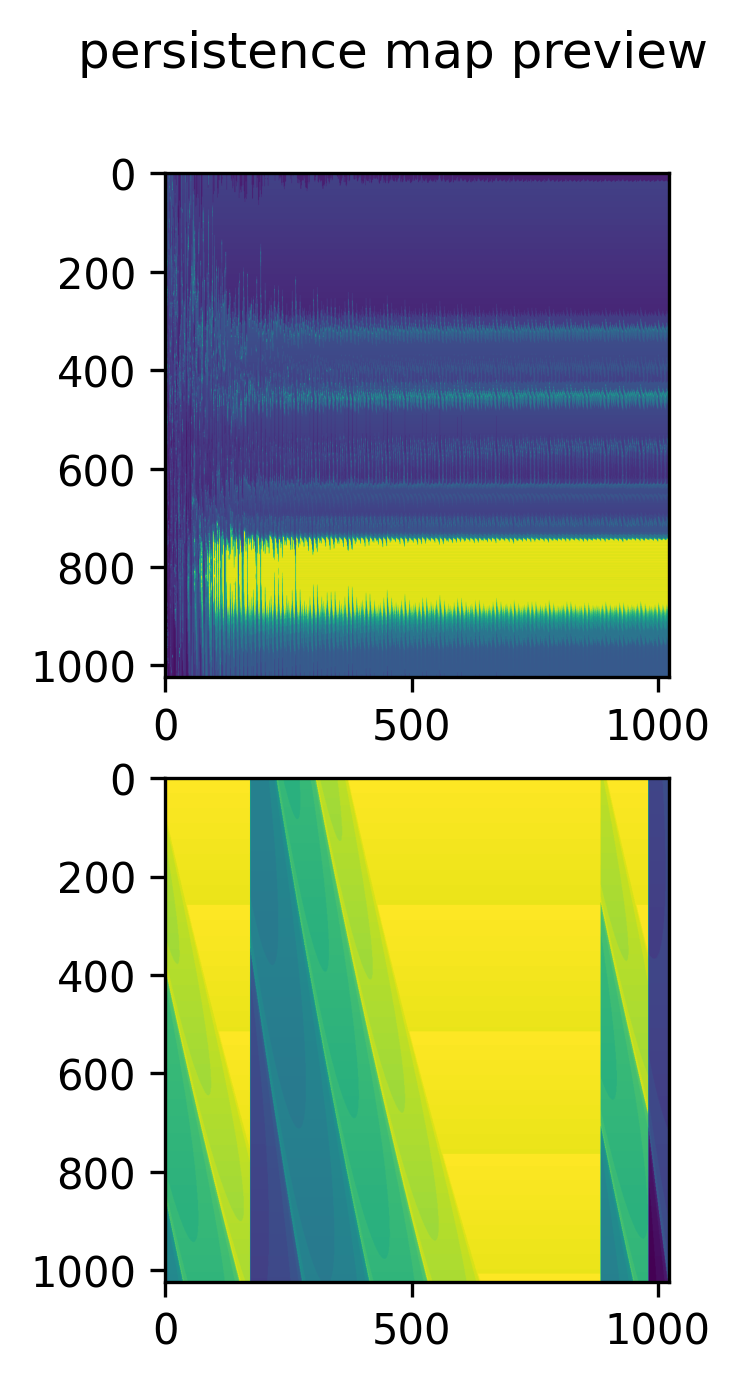

In [5]:
camera_ready = True

if(camera_ready):  
    # camera-ready figure (higher resolution, 1024x1024)
    folder_wide = os.path.join("..","results","asymdrop_asymdrop_camera_ready_1717445637_5164382")
    filename_wide = "asymdrop_asymdrop_camera_ready_1717445637_5164382_accumulated_t_0.npy"
    
    folder_zoom = os.path.join("..", "results", "asymdrop_asymdrop_camera_ready_zoom_1717453115_4455545")
    filename_zoom = "asymdrop_asymdrop_camera_ready_zoom_1717453115_4455545_accumulated_t_0.npy"
else:
    # submission figure (lower resolution 256 by 256)
    folder_wide = os.path.join("..","results", "asymdrop_zoom_lentil_1712794055_7875893")
    filename_wide = "asymdrop_zoom_lentil_1712794055_7875893_accumulated_t_0.npy"
    
    folder_zoom = os.path.join("..", "results", "asymdrop_zoom_lentil_1712786558_7613692")
    filename_zoom = "asymdrop_zoom_lentil_1712786558_7613692_accumulated_t_0.npy"
    
filepath_wide = os.path.join(folder_wide, filename_wide)
filepath_zoom = os.path.join(folder_zoom, filename_zoom)

acc_t_wide = np.load(filepath_wide)[:,:,:,0]
acc_t_zoom = np.load(filepath_zoom)[:,:,:,0]

plt.figure()
plt.subplot(212)
plt.imshow(acc_t_zoom.squeeze())
plt.subplot(211)
plt.imshow(acc_t_wide.squeeze())
plt.suptitle("persistence map preview")
plt.show()



In [6]:
if camera_ready:
    p_steps = 1024
else:
    p_steps = 256
    
max_t = 10.0
g_cmap = plt.get_cmap("Greens")#(x)#[...,:3]
b_cmap = plt.get_cmap("Blues")#(x)#[...,:3]

min_dt_w = 0.001
max_dt_w = 1.01
min_kr_w = 4
max_kr_w = 64

min_dt_z = 0.135
max_dt_z = 0.1428125
min_kr_z = 51.28125
max_kr_z = 51.8125

kr_w = np.arange(min_kr_w, max_kr_w, (max_kr_w - min_kr_w) / p_steps)
if camera_ready:
    
    dt_w = list(np.arange(min_dt_w, max_dt_w, (max_dt_w - min_dt_w) / p_steps))
    dt_z = list(np.arange(min_dt_z, max_dt_z, (max_dt_z - min_dt_z) / p_steps))
    
    dt_w.reverse()
    dt_z.reverse()
    dt_w = np.array(dt_w)
    dt_z = np.array(dt_z)
    
else:
    dt_w = np.arange(max_dt_w - (max_dt_w - min_dt_w) / p_steps, \
            min_dt_w-(max_dt_w - min_dt_w) / p_steps-.0005, \
            -(max_dt_w - min_dt_w) / p_steps)
    dt_z = np.arange(max_dt_z - (max_dt_z - min_dt_z) / p_steps,\
            min_dt_z - (max_dt_z - min_dt_z) / p_steps-.0005, \
            -(max_dt_z - min_dt_z) / p_steps)
    dt_w = np.arange(min_dt_w, max_dt_w, (max_dt_w - min_dt_w) / p_steps)
    dt_z = np.arange(min_dt_z, max_dt_z, (max_dt_z - min_dt_z) / p_steps)

kr_z = np.arange(min_kr_z, max_kr_z, (max_kr_z - min_kr_z) / p_steps)
    
display_zoom = np.zeros((*acc_t_zoom.shape[:2], 4))
display_wide = np.zeros((*acc_t_wide.shape[:2], 4))   

#acc_t_zoom[acc_t_zoom >= max_t].shape, display_zoom[acc_t_zoom >= max_t].shape
display_zoom = display_zoom.at[(acc_t_zoom >= max_t).squeeze()].set(g_cmap((acc_t_zoom/max_t)[(acc_t_zoom >= max_t).squeeze()]).squeeze())
display_zoom = display_zoom.at[(acc_t_zoom < max_t).squeeze()].set(b_cmap((acc_t_zoom/max_t)[(acc_t_zoom < max_t).squeeze()]).squeeze())

display_wide = display_wide.at[(acc_t_wide >= max_t).squeeze()].set(g_cmap((acc_t_wide/max_t)[(acc_t_wide >= max_t).squeeze()]).squeeze())
display_wide = display_wide.at[(acc_t_wide < max_t).squeeze()].set(b_cmap((acc_t_wide/max_t)[(acc_t_wide < max_t).squeeze()]).squeeze())


In [7]:

dt_w.shape, 

((1024,),)

In [8]:
min_dt_z = 0.135
max_dt_z = 0.1428125
min_kr_z = 51.28125
max_kr_z = 51.8125

dt_w[879], dt_w[879+8], kr_w[816], kr_w[816-10]

# interpolate for dt = 0.135
under = 960
over = 840
dt = 0.135
interp = (dt_w[over]- dt) / (dt_w[over] - dt_w[under])
dt_lower = over * (1-interp) + under * interp
print(f"interpolated coord for dt = {dt}: {dt_lower}, "\
      f"between {dt_w[int(np.floor(dt_lower))]} and {dt_w[int(np.ceil(dt_lower))]}")

# interpolate for dt = 0.1428125
under = 960
over = 840
dt = 0.1428125
interp = (dt_w[over]- dt) / (dt_w[over] - dt_w[under])
dt_upper = over * (1-interp) + under * interp
print(f"interpolated coord for dt = {dt}: {dt_upper}, "\
      f"between {dt_w[int(np.floor(dt_upper))]} and {dt_w[int(np.ceil(dt_upper))]}")
dt_diff = dt_upper - dt_lower

# interpolate for kr = 51.28125
over = 900
under = 650
kr = 51.28125
interp = (kr_w[over]-kr)/(kr_w[over] - kr_w[under])
kr_lower = over * (1 - interp) + under * interp
print(f"interpolated coord for kr = {kr}: {kr_lower}, between {kr_w[int(np.floor(kr_lower))]} and {kr_w[int(np.ceil(kr_lower))]}")



# interpolate for kr = 51.8125
over = 900
under = 650
kr = 51.8125
interp = (kr_w[over]-kr)/(kr_w[over] - kr_w[under])
kr_upper = over * (1 - interp) + under * interp
print(f"interpolated coord for kr = {kr}: {kr_upper}, between {kr_w[int(np.floor(kr_upper))]} and {kr_w[int(np.ceil(kr_upper))]}")
kr_diff = kr_upper- kr_lower
                       
# interpolate marker location in kr
over = 156
under = 150
interp = (kr_w[over]-k0)/(kr_w[over] - kr_w[under])
kr_marker = over * (1 - interp) + under * interp
print(f"interpolated coord for kr = {k0}: {kr_marker}, between {kr_w[int(np.floor(kr_marker))]} and {kr_w[int(np.ceil(kr_marker))]}")

# interpolate marker coordinate for dt=0.17
under = 860
over = 840
dt = 0.17
interp = (dt_w[over]- dt) / (dt_w[over] - dt_w[under])
dt_0_17_marker = over * (1-interp) + under * interp
print(f"interpolated coord for dt = {dt}: {dt_0_17_marker}, "\
      f"between {dt_w[int(np.floor(dt_0_17_marker))]} and {dt_w[int(np.ceil(dt_0_17_marker))]}")


# interpolate marker coordinate for dt=0.20
under = 900
over = 800
dt = 0.20
interp = (dt_w[over]- dt) / (dt_w[over] - dt_w[under])
dt_0_20_marker = over * (1-interp) + under * interp
print(f"interpolated coord for dt = {dt}: {dt_0_20_marker}, "\
      f"between {dt_w[int(np.floor(dt_0_20_marker))]} and {dt_w[int(np.ceil(dt_0_20_marker))]}")


# interpolate marker coordinate for dt=0.26
under = 900
over = 800
dt = 0.26
interp = (dt_w[over]- dt) / (dt_w[over] - dt_w[under])
dt_0_26_marker = over * (1-interp) + under * interp
print(f"interpolated coord for dt = {dt}: {dt_0_26_marker}, "\
      f"between {dt_w[int(np.floor(dt_0_26_marker))]} and {dt_w[int(np.ceil(dt_0_26_marker))]}")
  

interpolated coord for dt = 0.135: 887.0079345703125, between 0.1350078135728836 and 0.13402245938777924
interpolated coord for dt = 0.1428125: 879.079345703125, between 0.14289061725139618 and 0.1419052630662918
interpolated coord for kr = 51.28125: 806.933349609375, between 51.2265625 and 51.28515625
interpolated coord for kr = 51.8125: 816.0, between 51.8125 and 51.8125
interpolated coord for kr = 13: 153.60000610351562, between 12.96484375 and 13.0234375
interpolated coord for dt = 0.17: 851.4876098632812, between 0.17048045992851257 and 0.1694951057434082
interpolated coord for dt = 0.2: 821.0416259765625, between 0.2000410109758377 and 0.19905565679073334
interpolated coord for dt = 0.26: 760.1497192382812, between 0.26014742255210876 and 0.2591620683670044


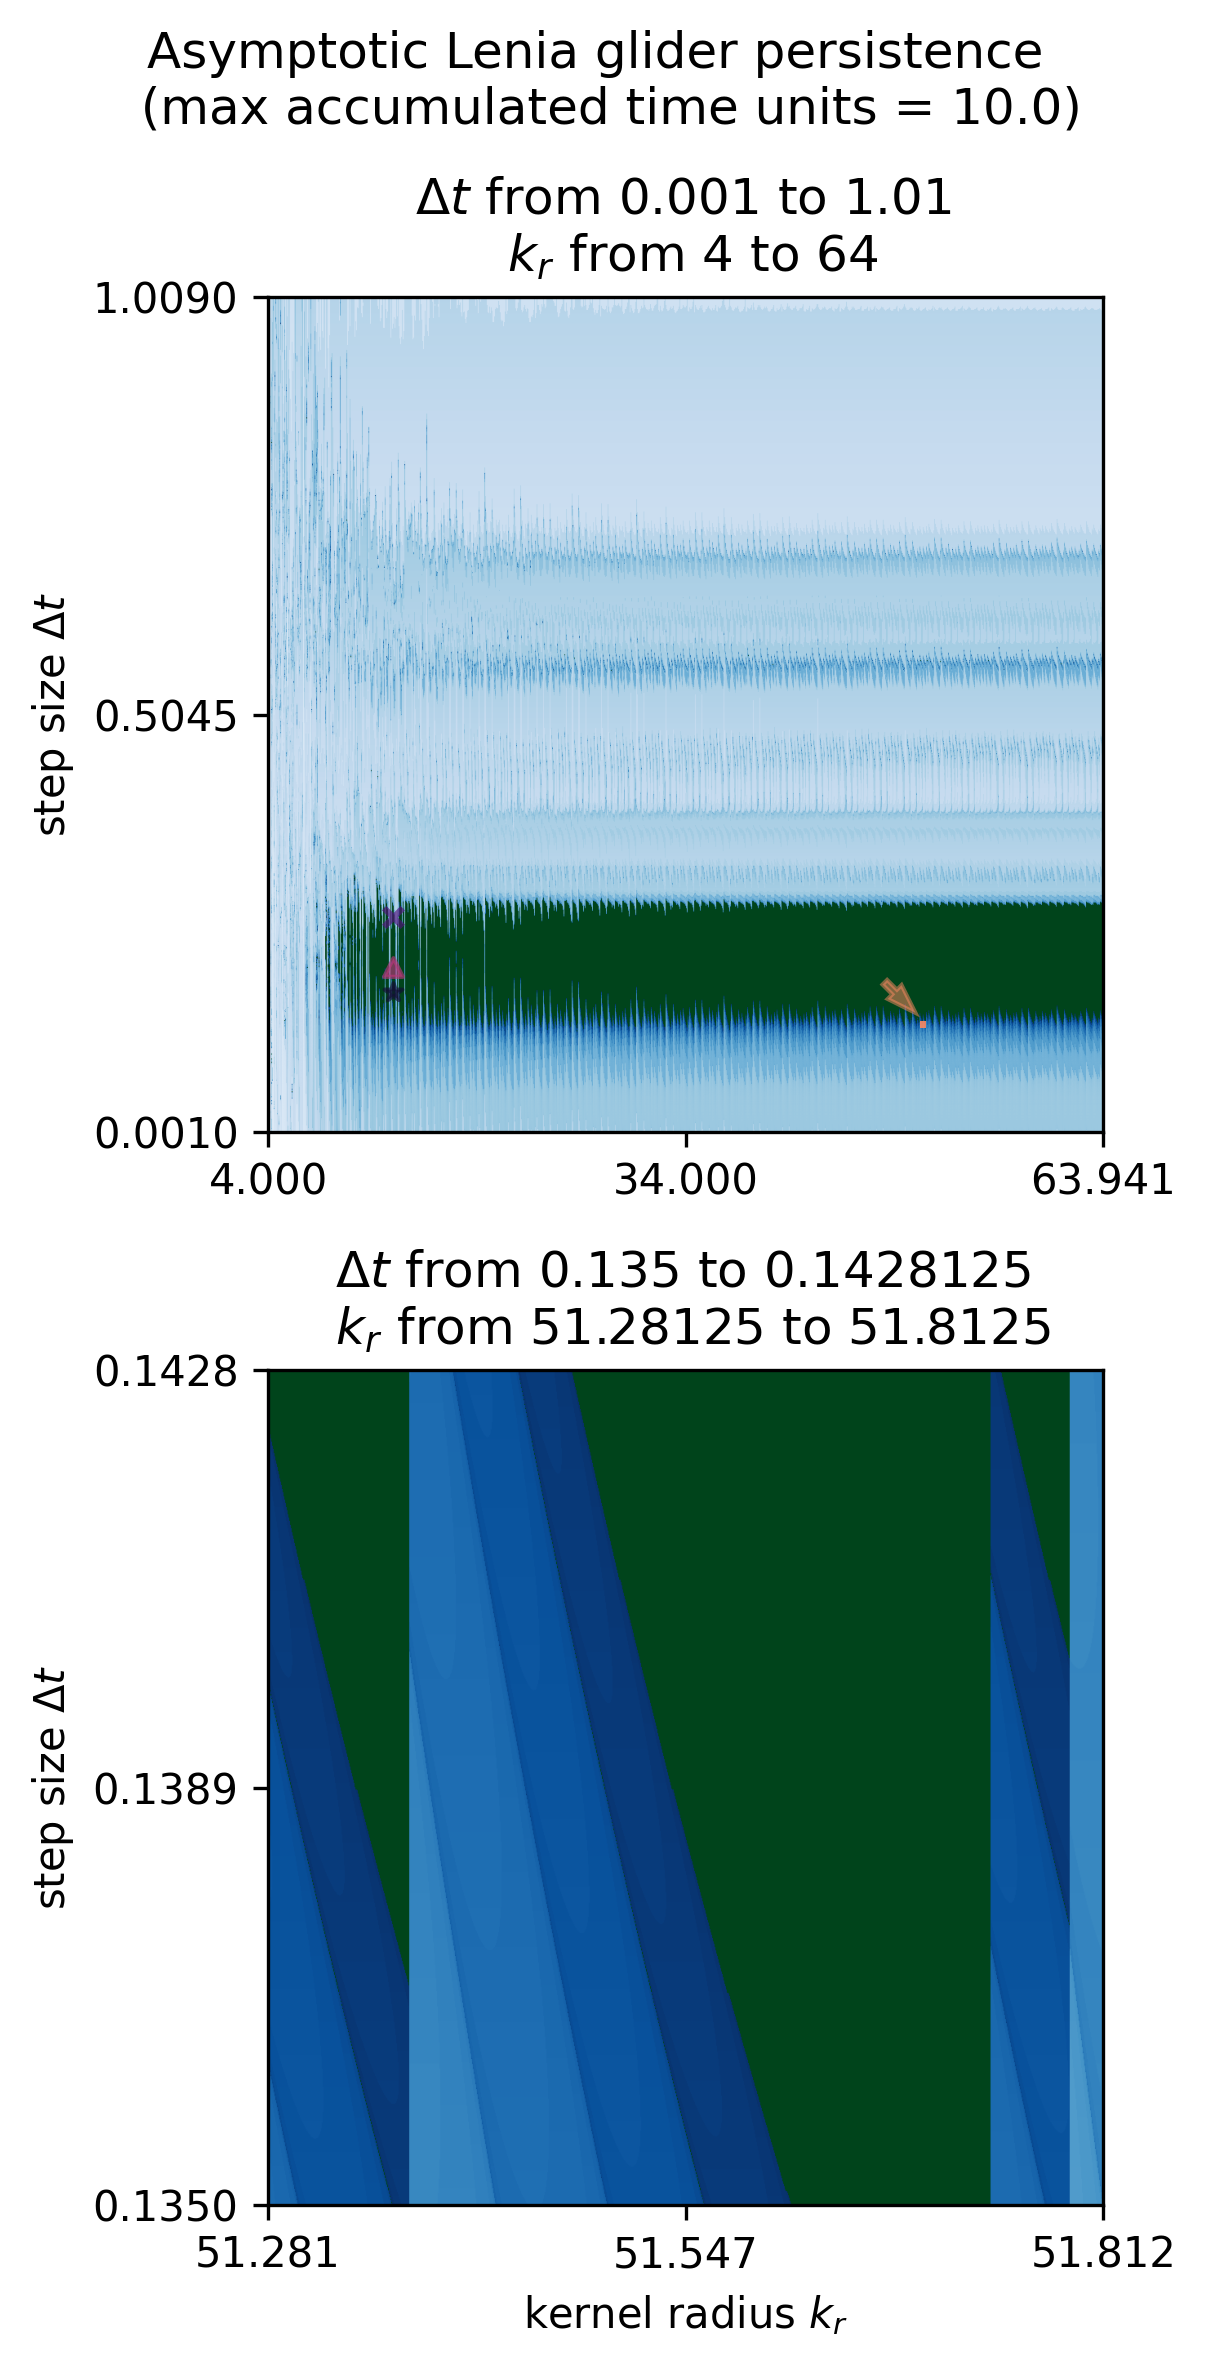

In [9]:

fig, ax = plt.subplots(2,1, figsize=(4,8))

ax[0].imshow(display_wide)

if camera_ready:
    # high resolution (1024 by 1024)

    
    dt_w[881], dt_w[881+8], kr_w[816], kr_w[816-10]
    
    rect_w = kr_diff
    rect_h = dt_diff
    corner_w = kr_lower
    corner_h = dt_lower
    rectangle_color = [elem.item() for elem in plt.get_cmap("magma")(0.75)]
    rectangle = matplotlib.patches.Rectangle((corner_w, corner_h),\
            rect_h, rect_w, linewidth=0, alpha=0.9,\
            edgecolor=rectangle_color, facecolor=rectangle_color)
    arrow_w = 756
    arrow_h = 840
    ax[0].arrow(arrow_w, arrow_h, 12, 12, width=8, lw=1, color=rectangle_color, alpha=0.5)
    ax[0].add_patch(rectangle)

   
    marker_0_17 = (kr_marker, dt_0_17_marker)
    marker_0_20 = (kr_marker, dt_0_20_marker)
    marker_0_26 = (kr_marker, dt_0_26_marker)
    
    ax[0].scatter(marker_0_17[0], marker_0_17[1], s=20, marker="*",alpha=0.65, color=line_color_2)
    
    ax[0].scatter(marker_0_20[0], marker_0_20[1], s=20, marker="^",alpha=0.65, color=line_color_1)
    ax[0].scatter(marker_0_26[0], marker_0_26[1], s=20, marker="x", alpha=0.65, color=line_color_3)

else:
    # submission figure (lower resolution, 256 by 256)  
    rect_width = 4
    rect_height = 3
    corner_w = 201
    corner_h = 34
    rectangle_color = [elem.item() for elem in plt.get_cmap("magma")(0.75)]
    rectangle = matplotlib.patches.Rectangle((201, 34), 4, 3, linewidth=1, edgecolor=rectangle_color, facecolor=rectangle_color)
    ax[0].arrow(227, 60, -3, -3, width=5, lw=1, color=rectangle_color, alpha=0.5)
    ax[0].add_patch(rectangle)

    rect_dt = (dt_w[corner_h], dt_w[corner_h+rect_height])
    rect_kr = (kr_w[corner_w], kr_w[corner_w+rect_width])
    
    print(f"rectangle boxes dt = {rect_dt[0]} to {rect_dt[1]} and kr = {rect_kr[0]} to  {rect_kr[1]}")

ax[1].imshow(display_zoom)

fig.suptitle("Asymptotic Lenia glider persistence \n (max accumulated time units = 10.0)")
ax[0].set_title(f"$\Delta t$ from {min_dt_w} to {max_dt_w} \n $k_r$ from {min_kr_w} to {max_kr_w}")
ax[1].set_title(f"$\Delta t$ from {min_dt_z} to {max_dt_z} \n $k_r$ from {min_kr_z} to {max_kr_z}")

ax[0].set_ylabel("step size $\Delta t$")
ax[1].set_ylabel("step size $\Delta t$")
ax[1].set_xlabel("kernel radius $k_r$")

ax[0].set_yticks([elem for elem in (0, p_steps//2, p_steps)])
ax[0].set_xticks([elem for elem in (0, p_steps//2, p_steps)])

ax[1].set_yticks([elem for elem in (0, p_steps//2, p_steps)])
ax[1].set_xticks([elem for elem in (0, p_steps//2, p_steps)])

ax[0].set_yticklabels([f"{dt_w[0]:.4f}", f"{dt_w[p_steps//2]:.4f}", f"{dt_w[-1]:.4f}"])
ax[0].set_xticklabels([f"{kr_w[0]:.3f}", f"{kr_w[p_steps//2]:.3f}", f"{kr_w[-1]:.3f}"])

ax[1].set_yticklabels([f"{dt_z[0]:.4f}", f"{dt_z[p_steps//2]:.4f}", f"{dt_z[-1]:.4f}"])
ax[1].set_xticklabels([f"{kr_z[0]:.3f}", f"{kr_z[p_steps//2]:.3f}", f"{kr_z[-1]:.3f}"])

plt.tight_layout()
plt.savefig("asymdrop_nonplatonic.png")